In [1]:
import numpy as np
import extracted_data_reader
from tsai.all import *

In [13]:
# initialization variables
show_splitting_dist = True
show_images = True
find_best_lr = True

ex_number = 5
frame_number = "max" # mean, max or min
target = "width" # goal, width, head, shoulders or trunk
epochs_number = 20
batch_size = 32

In [14]:
# get training data
X = np.array(extracted_data_reader.read_data_ex(ex_number=ex_number, frame_number=frame_number))
Y = extracted_data_reader.read_target_ex(ex_number=ex_number)
TARGETS_LABELS = ["goal","width","head","shoulders","trunk"]

In [15]:
# load target data
y = [y[TARGETS_LABELS.index(target)] for y in Y]

print(len(y))

216


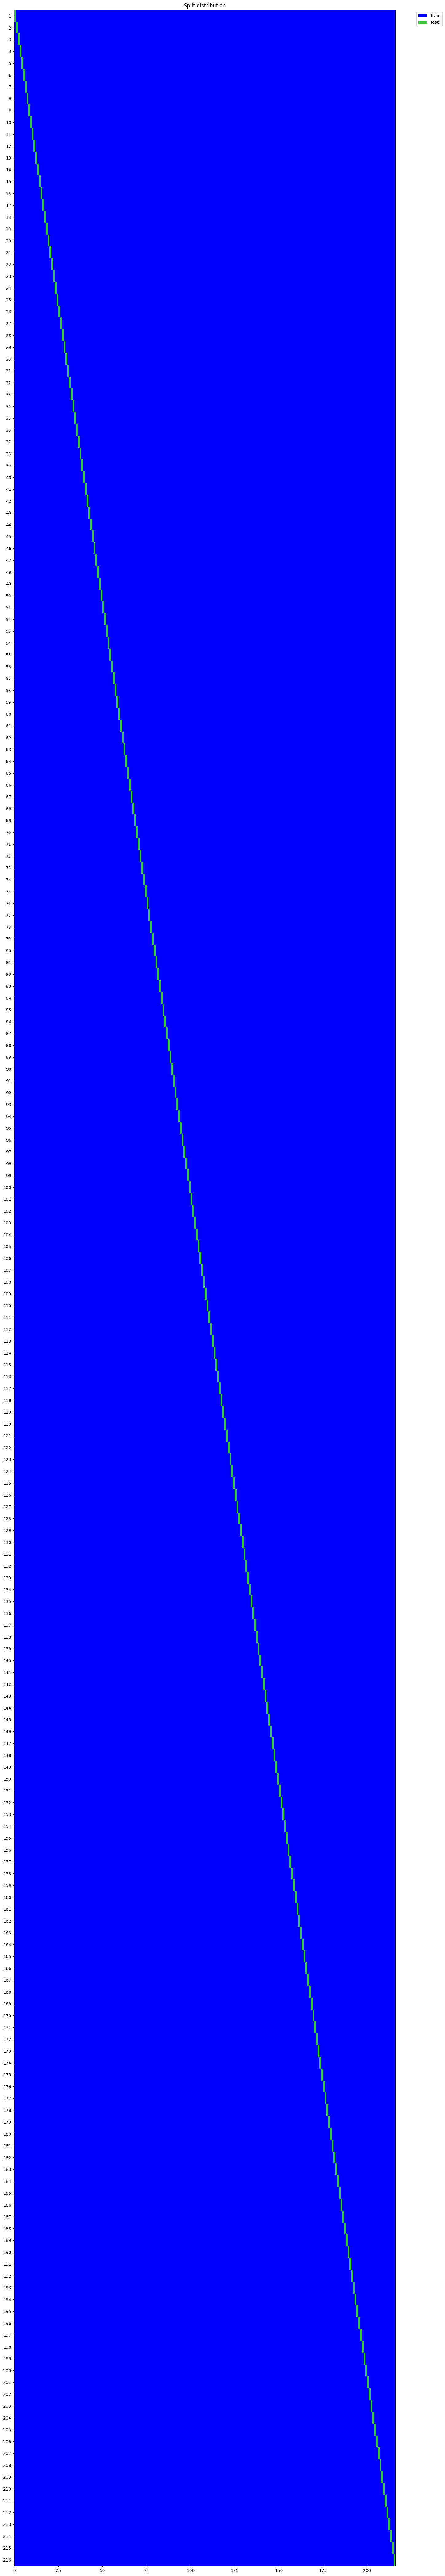

In [16]:
# split dataset with leave-one-out
splits = get_splits(y, n_splits=len(y), shuffle=False, show_plot=show_splitting_dist)

In [17]:
# create datasets
tfms  = [None, [Categorize()]]
dsets = []
for split in splits:
    dsets.append(TSDatasets(X, y, splits=split, tfms=tfms, inplace=True))

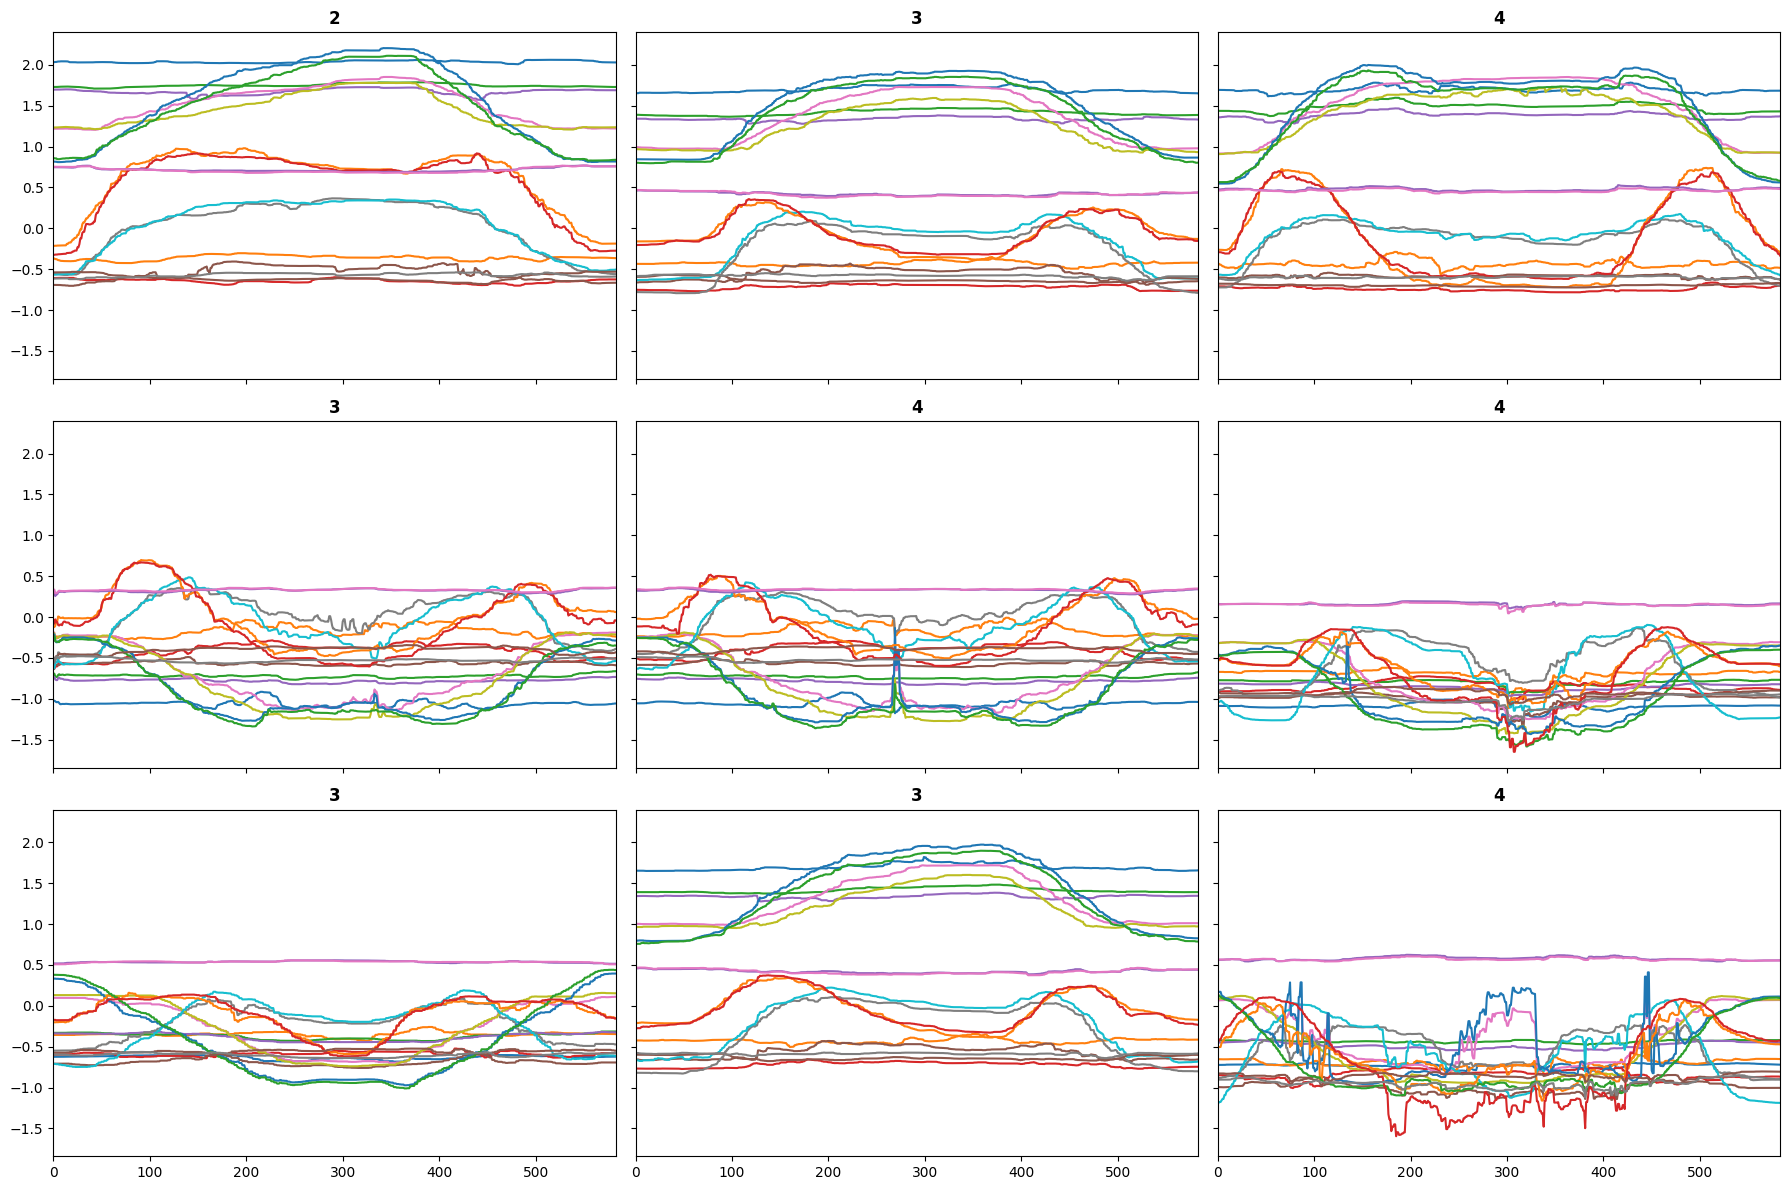

In [18]:
# load datasets
dls = TSDataLoaders.from_dsets(*dsets, bs=batch_size, batch_tfms=[TSStandardize()], num_workers=0)
if show_images: dls.show_batch(sharey=True)

In [19]:
# create model
model = InceptionTime(dls.vars, dls.c)

# create learner
learn = Learner(dls, model, metrics=accuracy)
# if find_best_lr: learn.lr_find()

In [20]:
# fit model and show metrics
learn.fit_one_cycle(epochs_number, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.597893,1.514346,0.032407,00:22
1,1.414928,1.467370,0.106481,00:23
2,1.230376,1.314449,0.486111,00:21
3,1.084488,0.955107,0.787037,00:21
4,0.977419,0.825605,0.717593,00:21
5,0.887372,0.513374,0.861111,00:22
6,0.821137,0.574910,0.851852,00:29
7,0.762443,0.637508,0.791667,00:31
8,0.705753,0.366799,0.925926,00:28
9,0.661323,0.355991,0.921296,00:21


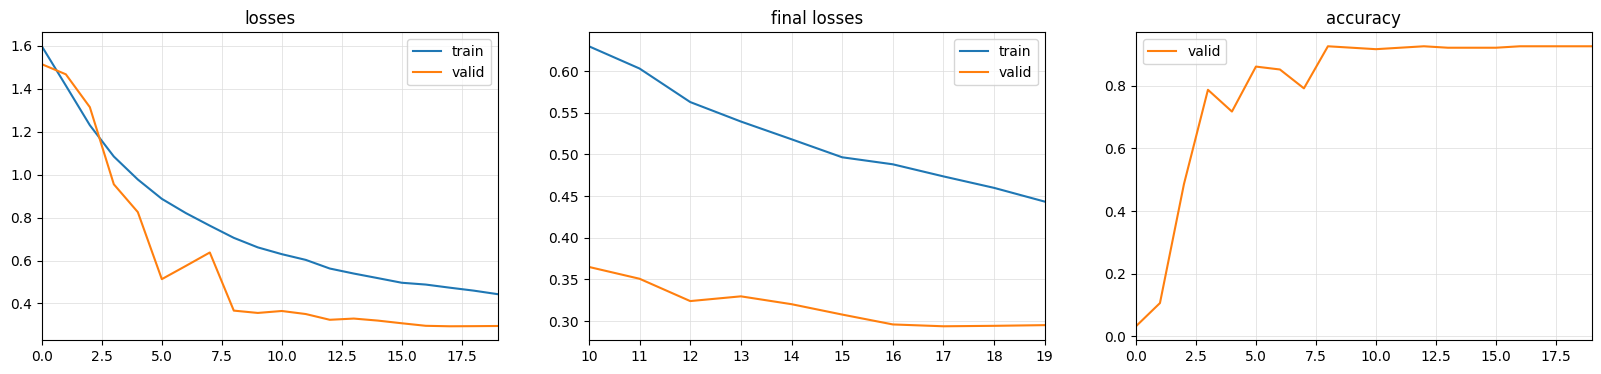

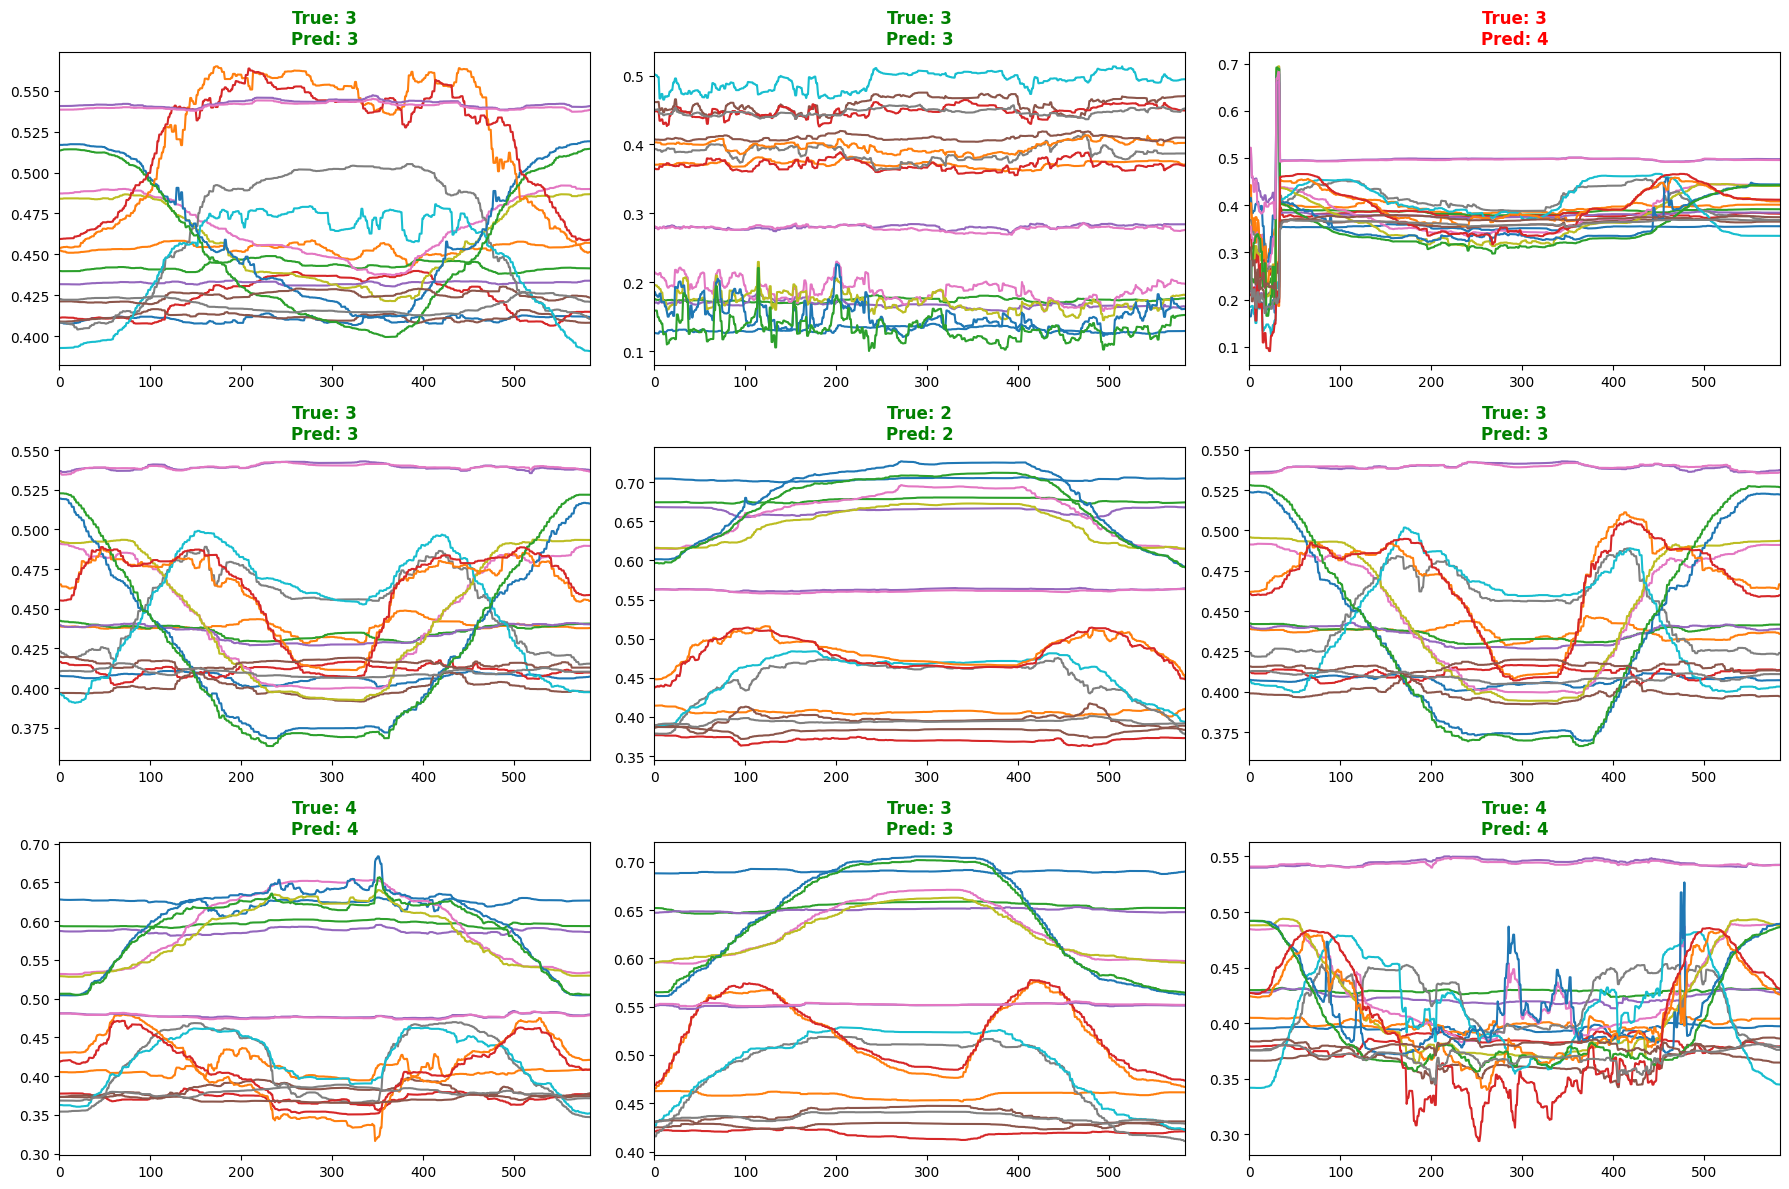

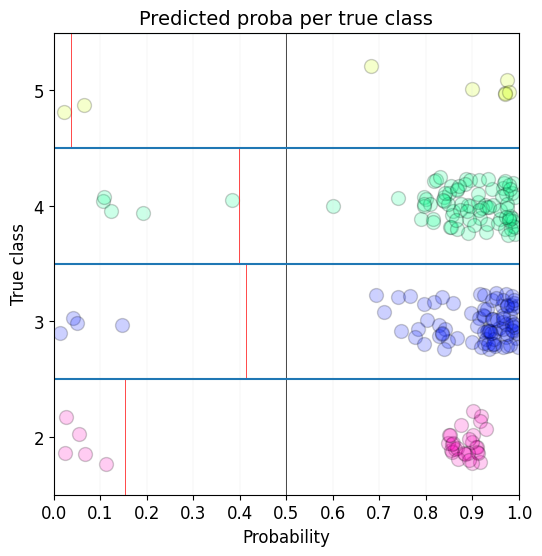

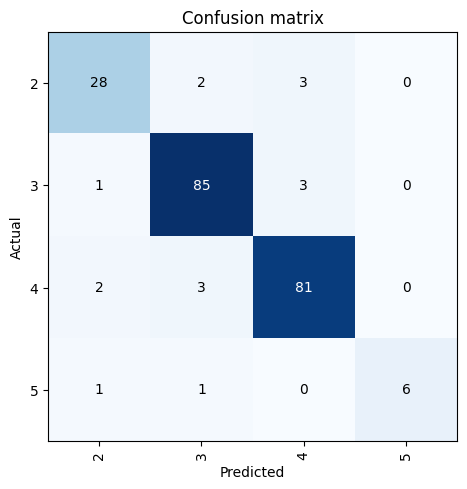

In [21]:
learn.recorder.plot_metrics()
learn.show_results()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [22]:
# save learner
stage_name = f"ex-{ex_number}_stage0_{target}_fn-{frame_number}"
# learn.save(stage_name)

learn.save_all(path=f'models_export/ex{ex_number}/', dls_fname=f'dls/{frame_number}_ex{ex_number}_{target}_dls', 
               model_fname=f'{frame_number}_ex{ex_number}_{target}', 
               learner_fname=f'{frame_number}_ex{ex_number}_{target}_learner')

#learn.load(stage_name)